C:\Users\PC\AppData\Local\Temp\ipykernel_12708\774109698.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


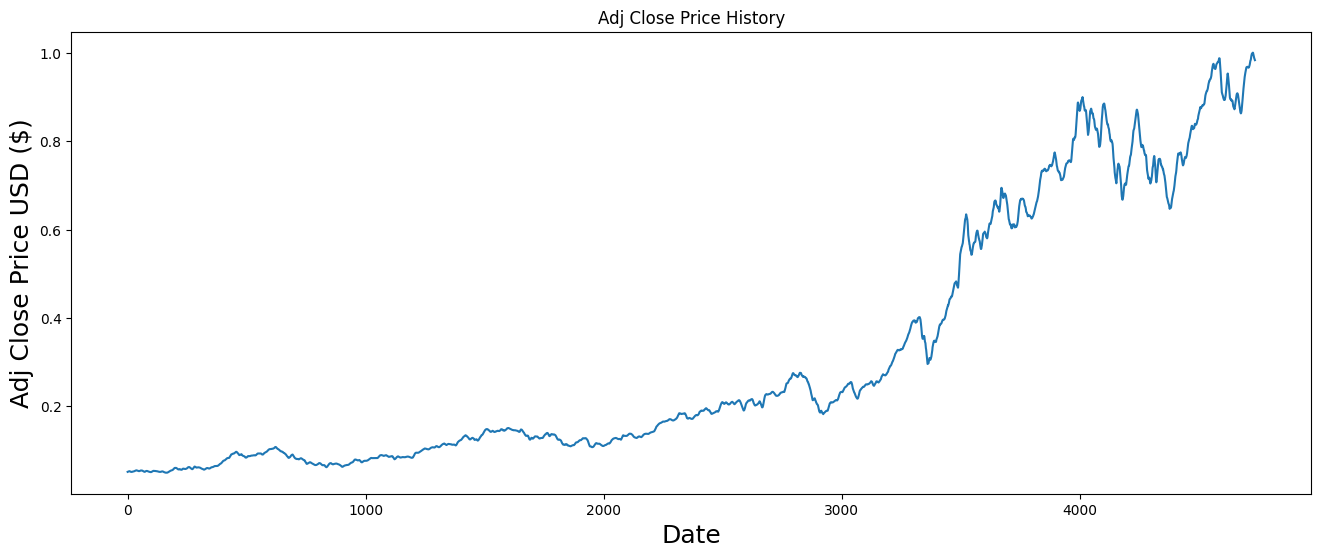

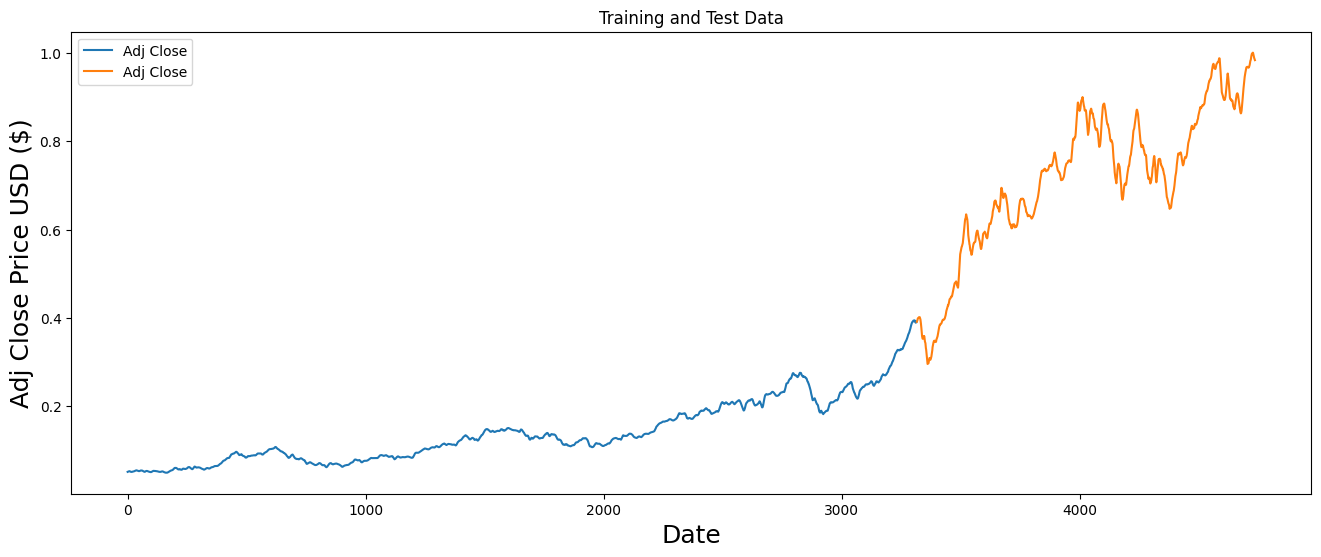

Failed to load model: No file or directory found at ..\..\lstm_stock_predict_v12.keras
Training model...



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12, 128)           512       
                                                                 
 max_pooling1d (MaxPooling1  (None, 6, 128)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 6, 50)             35800     
                                                                 
 dropout (Dropout)           (None, 6, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 6, 50)             20200     
                                                                 
 dropout_1 (Dr

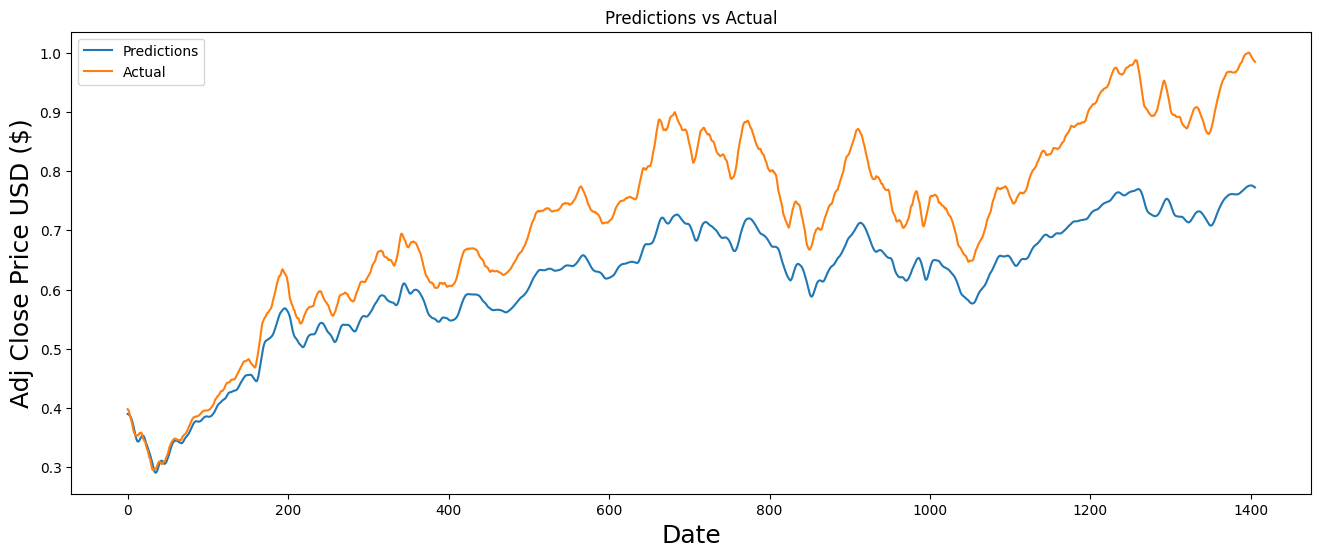

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.models import load_model
from keras.layers import Dropout,Conv1D, MaxPooling1D, Flatten

import math
from sklearn.preprocessing import MinMaxScaler

def import_data_from_csv(path: str):
    """
    Imports data from a csv file and returns a pandas dataframe.
    """
    return pd.read_csv(path)

def extract_features_required_for_training(df: pd.DataFrame, features: list[str]) -> pd.DataFrame:
    """
    Extracts features required for training.
    """
    return df[features]

def split_data_into_training_and_test_sets(df: pd.DataFrame, train_ratio: float) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits the data into training and test sets based on the given ratio.
    """
    train_size = int(len(df) * train_ratio)
    train_data = df.iloc[0:train_size]
    test_data = df.iloc[train_size:len(df)]
    return train_data, test_data

def create_dataset(dataset: pd.DataFrame, time_step = 1) -> tuple[np.ndarray, np.ndarray]:
    """
    Creates a dataset.
    """
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX),np.array(dataY)

def create_model(X_train):
    model = Sequential()

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))  # Add a 1D CNN layer
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(50))
    model.add(Dropout(0.2))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()

    return model
    

def train_and_save_model(model, X_train, Y_train, batch_size, epochs):    
    model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs)
    model.save('lstm_stock_predict_v3.keras')

    return model

def plot_data(loaded_data, title: str, xlabel: str, ylabel: str, datacolumn: str):
    """
    Plots the data from the dataframe.
    """
    plt.figure(figsize=(16,6))
    plt.title(title)
    plt.plot(loaded_data[datacolumn])
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.show()

def plot_data_list(loaded_data_list, title: str, xlabel: str, ylabel: str, datacolumns: list):
    """
    Plots the data from the dataframe.
    """
    plt.figure(figsize=(16,6))
    plt.title(title)
    for loaded_data, datacolumn in zip(loaded_data_list, datacolumns):
        plt.plot(loaded_data, label=datacolumn)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.legend()
    plt.show()

def walk_forward_method(model, X, y):
    W, T = 800, 400
    N = X.shape[0]
    rmse_list = []
    
    # Walk Forward Validation
    for i in range(0, N - W, T):
        try:
            train_X, train_y = X[i:i+W], y[i:i+W]
            test_X, test_y = X[i+W:i+W+T], y[i+W:i+W+T]
            
            # Train model
            model = train_and_save_model(model, train_X, train_y, batch_size=20, epochs=25)
            
            # Test model
            predictions = model.predict(test_X)
            rmse = np.sqrt(np.mean(((predictions - test_y) ** 2)))
            rmse_list.append(rmse)
            
            print(f"Test window {i+W}-{i+W+T}: RMSE = {rmse}")
        except e:
            print("==================")
            print(e)
            print("==================")
    return model

def main():
    #scaler = MinMaxScaler(feature_range=(0,1))
     
    loaded_data = import_data_from_csv("..\\..\\data\\processed\\AAPL.csv")
    extracted_data = extract_features_required_for_training(loaded_data, ["Adj Close"])
    # Plot the data
    plot_data(extracted_data, 'Adj Close Price History', 'Date', 'Adj Close Price USD ($)', 'Adj Close')

    #scaled_data = scaler.fit_transform(extracted_data)
    #scaled_data_df = pd.DataFrame(scaled_data, columns=extracted_data.columns)

    training_data, test_data = split_data_into_training_and_test_sets(extracted_data, 0.70)

    plot_data_list([training_data, test_data], 'Training and Test Data', 'Date', 'Adj Close Price USD ($)', ['Adj Close', 'Adj Close'])

    time_step = 14
    X_train, Y_train =  create_dataset(training_data, time_step)
    X_test, Y_test =  create_dataset(test_data, time_step)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    try:
        # Load the model
        model = load_model('..\\..\\lstm_stock_predict_v12.keras')
    except Exception as e:
        print(f"Failed to load model: {e}")
        print("Training model...")
        model = create_model(X_train)
        # model = train_and_save_model(model,X_train, Y_train, batch_size=20, epochs=25)
        model = walk_forward_method(model,X_train,Y_train)
        
    if model is not None:
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] ,1))
        predictions = model.predict(X_test)
        rmse = np.sqrt(np.mean(((predictions - Y_test) ** 2)))
        print(rmse)

        #predictions = scaler.inverse_transform(predictions)
        #Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
        plot_data_list([predictions, Y_test], 'Predictions vs Actual', 'Date', 'Adj Close Price USD ($)', ['Predictions', 'Actual'])
    else:
        print("Model is None, cannot make predictions")


if __name__ == "__main__":
    main()